In [1]:
%config Completer.use_jedi = False

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Config option `use_jedi` not recognized by `IPCompleter`.
  """Entry point for launching an IPython kernel.


In [3]:
import os
from collections import defaultdict
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

import scipy
from scipy.stats import multivariate_normal

import torch.utils.data as data

In [11]:
def load_pickle(path):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    train_data, test_data = data['train'] > 255/2, data['test'] > 255/2
    train_labels, test_labels = data['train_labels'], data['test_labels']
    return train_data, test_data, train_labels, test_labels


def show_samples(samples, title=None, nrow=10):
    samples = (torch.FloatTensor(samples)).permute(0, 3, 1, 2)
    grid_img = make_grid(samples, nrow=nrow)
    plt.figure(figsize=(10,10))
    if title is not None:
        plt.title(title)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')
    plt.show()


def visualize_data(data, title):
    idxs = np.random.choice(len(data), replace=False, size=(100,))
    images = data[idxs]
    show_samples(images, title)
    

def visualize_batch(batch, nrow=10):
    show_samples(batch[...,None], nrow=nrow)


def plot_training_curves(train_losses, test_losses):
    n_train = len(train_losses[list(train_losses.keys())[0]])
    n_test = len(test_losses[list(train_losses.keys())[0]])
    x_train = np.linspace(0, n_test - 1, n_train)
    x_test = np.arange(n_test)

    plt.figure()
    for key, value in train_losses.items():
        plt.plot(x_train, value, label=key + '_train')

    for key, value in test_losses.items():
        plt.plot(x_test, value, label=key + '_test')

    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

In [12]:
train_data, test_data, train_labels, test_labels = load_pickle('mnist.pkl')

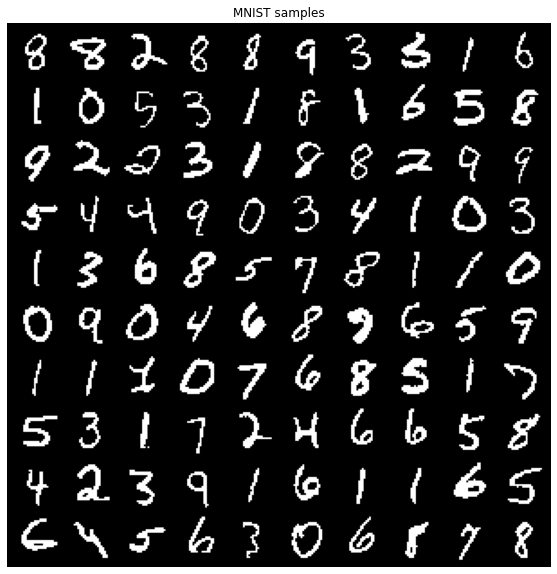

In [13]:
visualize_data(train_data, 'MNIST samples')

In [14]:
def train_epoch(model, train_loader, optimizer, epoch, loss_key='total'):
    model.train()
    stats = defaultdict(list)
    for x in train_loader:
        x = x.cuda()
        losses = model.loss(x)
        optimizer.zero_grad()
        losses[loss_key].backward()
        optimizer.step()

        for k, v in losses.items():
            stats[k].append(v.item())
    return stats


def eval_model(model, data_loader):
    model.eval()
    stats = defaultdict(float)
    with torch.no_grad():
        for x in data_loader:
            x = x.cuda()
            losses = model.loss(x)
            for k, v in losses.items():
                stats[k] += v.item() * x.shape[0]

        for k in stats.keys():
            stats[k] /= len(data_loader.dataset)
    return stats


def train_model(model, train_loader, test_loader, epochs, lr, loss_key='total'):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = defaultdict(list)
    test_losses = defaultdict(list)
    for epoch in range(epochs):
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, epoch, loss_key)
        test_loss = eval_model(model, test_loader)

        for k in train_loss.keys():
            train_losses[k].extend(train_loss[k])
            test_losses[k].append(test_loss[k])
    return dict(train_losses), dict(test_losses)


def solve_task(train_data, test_data, model, batch_size, epochs, lr):
    train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)

    train_losses, test_losses = train_model(
        model, train_loader, test_loader, epochs=EPOCHS, lr=LR, loss_key='elbo_loss'
    )
    
    for key, value in test_losses.items():
        print('{}: {:.4f}'.format(key, value[-1]))

    plot_training_curves(train_losses, test_losses)

In [15]:
def get_batch_of_labels(label, batch_size, data_with_labels=(test_data, test_labels)):
    data, labels = data_with_labels
    idx = np.random.choice(np.argwhere(labels == label).flatten(), batch_size, replace=False)
    
    return data[idx][...,0]

def get_pdf(mu, sigma):
    x, y = np.mgrid[-5:5:0.05, -5:5:0.05]
    pos = np.dstack((x, y))
    rv = multivariate_normal(mu, [[sigma[0], 0],[0, sigma[1]]])
    return rv.pdf(pos)

def get_pic(mu, sigma):
    res = get_pdf(mu, sigma)
    pic = res.T[::-1,:]
    
    return pic

def get_pics(mu_s, sigma_s):
    return np.array([get_pic(m, s) for m,s in zip(mu_s, sigma_s)])

In [ ]:
#######

In [189]:
class LayerNorm(nn.LayerNorm):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, x):
        x = x.permute(0, 2, 3, 1).contiguous()
        x_shape = x.shape
        x = super().forward(x)
        return x.permute(0, 3, 1, 2).contiguous()


class MaskConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, conditional_size=None, **kwargs):
        assert mask_type == 'A' or mask_type == 'B'
        super().__init__(*args, **kwargs)
        self.register_buffer('mask', torch.zeros_like(self.weight))
        self.create_mask(mask_type)

        if conditional_size is not None:
            self.cond_op = nn.Linear(conditional_size, self.out_channels)

    def forward(self, input, cond=None):
        out = F.conv2d(input, self.weight * self.mask, self.bias, self.stride,
                       self.padding, self.dilation, self.groups)
        if cond is not None:
            cond = self.cond_op(cond)
            out = out + cond.view(cond.shape[0], self.out_channels, 1, 1)
        return out

    def create_mask(self, mask_type):
        k = self.kernel_size[0]
        self.mask[:, :, :k // 2] = 1
        self.mask[:, :, k // 2, :k // 2] = 1
        if mask_type == 'B':
            self.mask[:, :, k // 2, k // 2] = 1


class PixelCNN(nn.Module):
    def __init__(self, input_shape, n_colors, dim=256, n_layers=7, 
                 k=3, conditional_size=None):
        super().__init__()
        self.n_colors = n_colors
        self.input_shape = input_shape
        model = nn.ModuleList([MaskConv2d('A', input_shape[0], dim, k, padding=k // 2,
                                          conditional_size=conditional_size),
                               LayerNorm(dim), nn.ReLU()])
        for _ in range(n_layers - 1):
            model.append(MaskConv2d('B', dim, dim, k, padding=k // 2, 
                                    conditional_size=conditional_size))
        model.extend([LayerNorm(dim), nn.ReLU(),
                      MaskConv2d('B', dim, n_colors, 1, conditional_size=conditional_size)])
        self.net = model

    def forward(self, x, cond=None):
        out = 2 * (x.float() / (self.n_colors - 1)) - 1
        for layer in self.net:
            if isinstance(layer, MaskConv2d):
                out = layer(out, cond=cond)
            else:
                out = layer(out)
        return out.view(x.shape[0], self.n_colors, *self.input_shape)

    def loss(self, x, cond=None):
        return F.cross_entropy(self(x, cond=cond), x.long(), reduction='none').view(x.shape[0], -1).sum(1).mean()

    def sample(self, n, cond=None):
        samples = torch.zeros(n, *self.input_shape).cuda()
        with torch.no_grad():
            for r in range(self.input_shape[1]):
                for c in range(self.input_shape[2]):
                    for k in range(self.input_shape[0]):
                        logits = self(samples, cond=cond)[:, :, k, r, c]
                        logits = F.softmax(logits, dim=1)
                        samples[:, k, r, c] = torch.multinomial(logits, 1).squeeze(-1)
        return samples.permute(0, 2, 3, 1).cpu().numpy()

class ConvEncoder(nn.Module):
    def __init__(self, input_shape, latent_dim):
        super().__init__()
        self.input_shape = input_shape
        self.latent_dim = latent_dim

        self.convs = nn.Sequential(
            nn.Conv2d(input_shape[0], 8, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
        )
        conv_out_dim = input_shape[1] // 4 * input_shape[2] // 4 * 32
        self.fc = nn.Linear(conv_out_dim, 2 * latent_dim)

    def forward(self, x):
        out = self.convs(x)
        out = out.view(out.shape[0], -1)
        mu, log_std = self.fc(out).chunk(2, dim=1)
        return mu, log_std


class PixelVAE(nn.Module):
    def __init__(self, input_shape, latent_size):
        super().__init__()
        assert len(input_shape) == 3

        self.input_shape = input_shape
        self.latent_size = latent_size
        self.encoder = ConvEncoder(input_shape, latent_size)
        self.decoder = PixelCNN(input_shape, 2, dim=64, n_layers=2,
                                k=3, conditional_size=latent_size)

    def loss(self, x):
        x_scaled = 2 * x - 1
        mu, log_std = self.encoder(x_scaled)
        z = torch.randn_like(mu) * log_std.exp() + mu
        recon_loss = self.decoder.loss(x, cond=z)
        kl_loss = -log_std - 0.5 + (torch.exp(2 * log_std) + mu ** 2) * 0.5
        kl_loss = kl_loss.sum(1).mean()

        return {
            'total': recon_loss + kl_loss, 
            'recon_loss': recon_loss,
            'kl_loss': kl_loss
        }

    def sample(self, n):
        with torch.no_grad():
            z = torch.randn(n, self.latent_size).cuda()
            samples = self.decoder.sample(n, cond=z)
        return samples

In [190]:
######

In [191]:
BATCH_SIZE = 128
EPOCHS = 4
LR = 0.001

In [192]:
train_loader = data.DataLoader(train_data.transpose(0,3,1,2).astype(np.float32), batch_size=BATCH_SIZE, shuffle=True)#.cuda()
test_loader = data.DataLoader(test_data.transpose(0,3,1,2).astype(np.float32), batch_size=BATCH_SIZE)#.cuda()

In [193]:
model = PixelVAE((1, 28, 28), 2).cuda()

In [194]:
model

PixelVAE(
  (encoder): ConvEncoder(
    (convs): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (fc): Linear(in_features=1568, out_features=4, bias=True)
  )
  (decoder): PixelCNN(
    (net): ModuleList(
      (0): MaskConv2d(
        1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
        (cond_op): Linear(in_features=2, out_features=64, bias=True)
      )
      (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
      (3): MaskConv2d(
        64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
        (cond_op): Linear(in_features=2, out_features=64, bias=True)
      )
      (4): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (5): ReLU()
      (6): MaskConv2d(
        64, 2, kernel_size=(1, 1), stri

In [195]:
torch.cuda.get_device_name()

'Tesla P100-PCIE-16GB'

In [196]:
%%time
train_losses, test_losses = train_model(model, train_loader, test_loader, epochs=EPOCHS, lr=LR)

CPU times: user 29.2 s, sys: 15.6 s, total: 44.8 s
Wall time: 44.8 s


total: 82.2922
recon_loss: 80.4258
kl_loss: 1.8665


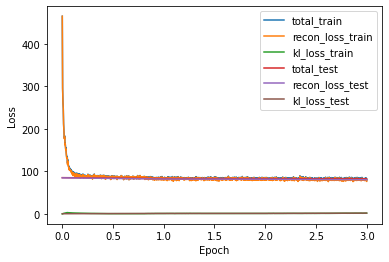

In [197]:
for key, value in test_losses.items():
    print('{}: {:.4f}'.format(key, value[-1]))
plot_training_curves(train_losses, test_losses)

In [198]:
samples = model.sample(100)

x = next(iter(test_loader))[:50].cuda()
with torch.no_grad():
    z, _ = model.encoder(2 * x - 1)
    x_recon = model.decoder.sample(50, cond=z)
x = x.permute(0, 2, 3, 1).cpu().numpy()
reconstructions = np.stack((x, x_recon), axis=1).reshape((-1, 28, 28, 1))

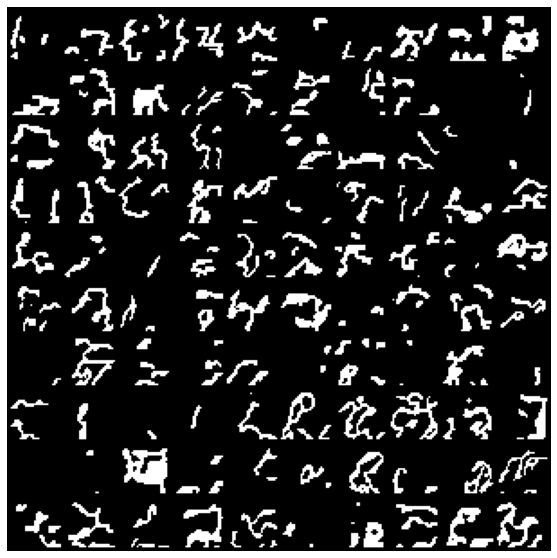

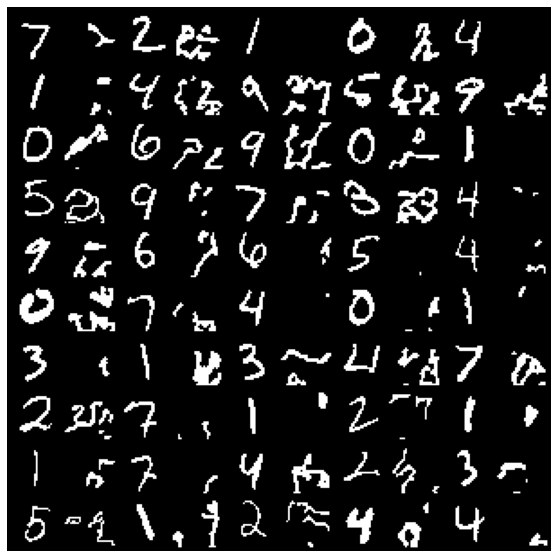

In [199]:
show_samples(samples)
show_samples(reconstructions)